# Finetune the pretrained R(2+1)D model

In [ ]:
# !git clone https://github.com/microsoft/computervision-recipes.git
# %cd computervision-recipes
# !pip install decord ipywebrtc einops nteract-scrapbook

Objective - to finetune the pretrained R(2+1)D model


In [4]:
import sys

sys.path.append("/content/computervision-recipes")

import numpy as np
import os
from pathlib import Path
import time
import warnings

from sklearn.metrics import accuracy_score
import scrapbook as sb
import torch
import torchvision

from utils_cv.action_recognition.data import Urls
from utils_cv.action_recognition.dataset import VideoDataset
from utils_cv.action_recognition.model import VideoLearner 
from utils_cv.common.gpu import system_info
from utils_cv.common.data import data_path, unzip_url

system_info()
warnings.filterwarnings('ignore')

3.6.9 (default, Oct  8 2020, 12:12:24) 
[GCC 8.4.0] 

PyTorch 1.7.0+cu101 

Torch-vision 0.8.1+cu101 

Available devices:
0: Tesla P100-PCIE-16GB


In [5]:
# Ensure edits to libraries are loaded and plotting is shown in the notebook.
%reload_ext autoreload
%autoreload 2
%matplotlib inline

Next, set some model runtime parameters. We use the `unzip_url` helper function to download and unzip the data used in this example notebook.

In [6]:
# Your data
DATA_PATH = unzip_url(Urls.milk_bottle_action_path, exist_ok=True)

# Number of consecutive frames used as input to the DNN. Use: 32 for high accuracy, 8 for inference speed.
MODEL_INPUT_SIZE = 8

# Number of training epochs
EPOCHS = 16

# Batch size. Reduce if running out of memory.
BATCH_SIZE = 8

# Learning rate
LR = 0.0001

## Prepare Action Recognition Dataset

In this notebook, we use a toy dataset called *Milk Bottle Actions*, which consists of 60 clips of 2 actions: `{opening, pouring}`. The same objects appear in both classes. 

After downloading the dataset, the `unzip_url` helper function will also unzip the dataset to the `data` directory.

In [7]:
os.listdir(Path(DATA_PATH))

['pouring', 'opening']

You'll notice that we have two different folders inside:
- `/pouring`
- `/opening`

Action videos can be stored as follows:

```
/data
+-- action_class_1
|   +-- video_01.mp4
|   +-- video_02.mp4
|   +-- ...
+-- action_class_2
|   +-- video_11.mp4
|   +-- video_12.mp4
|   +-- ...
+-- ...
```

For action recognition, the way data is stored can be as straight forward as putting the videos for each action inside a folder named after the action. 

## Load Images

To load the data, we need to create a VideoDataset object using the `VideoDataset` helper class. This class knows how to extract the dataset based on the above format. We simply pass it the path to the root dir of our dataset.

In [8]:
data = VideoDataset(DATA_PATH, batch_size=BATCH_SIZE, sample_length=MODEL_INPUT_SIZE)

The `VideoDataset` will automatically divide the data into a training/validation set and set up the dataloaders that PyTorch uses. Lets inspect our Datasets/DataLoaders to make sure the train/test split looks right.

In [9]:
print(
    f"Training dataset: {len(data.train_ds)} | Training DataLoader: {data.train_dl} \
    \nTesting dataset: {len(data.test_ds)} | Testing DataLoader: {data.test_dl}"
)

Training dataset: 45 | Training DataLoader: <torch.utils.data.dataloader.DataLoader object at 0x7f8fdd37dd68>     
Testing dataset: 15 | Testing DataLoader: <torch.utils.data.dataloader.DataLoader object at 0x7f8fd9643e80>


Lets take a look at the data by briefly looking at the frames.

<Figure size 432x288 with 0 Axes>

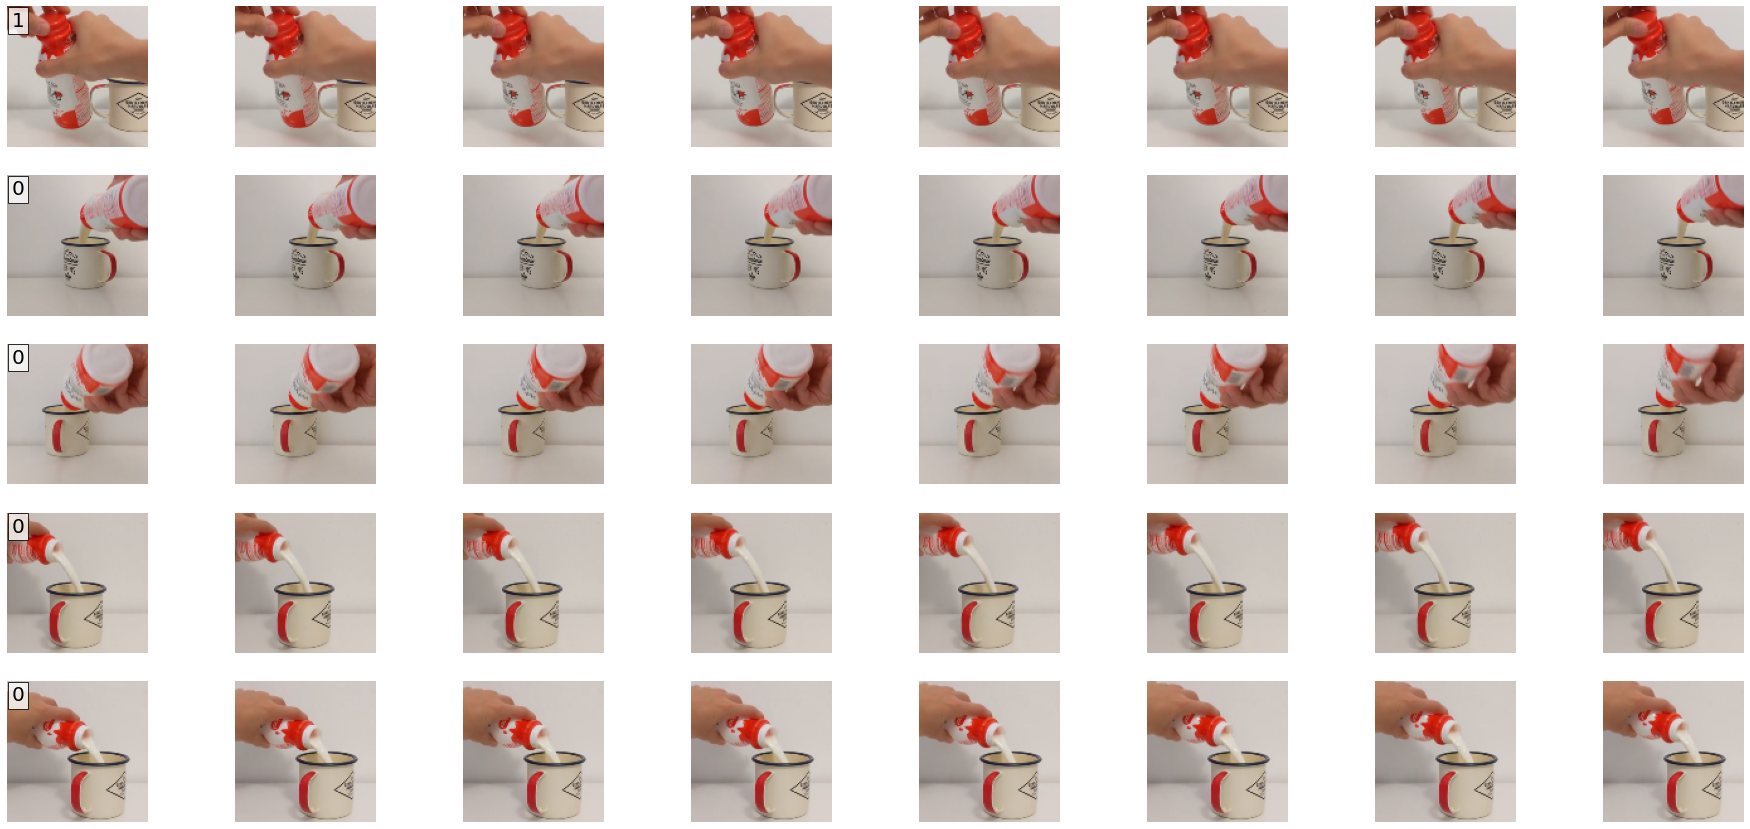

In [10]:
data.show_batch(rows=5, train_or_test="test")

## Finetune a Pretrained Model

By default, our VideoLearner's R(2+1)D model is pretrained on __ig65m__ which is based of 65 million instagram videos. You can find more information on the dataset in this paper: https://arxiv.org/pdf/1905.00561.pdf

When we initialize the VideoLearner, we simply pass in the dataset. By default, the object will set the model to torchvision's ig65m R(2+1)D pre-trained model. Alternatively, we can also select the R(2+1)D model pretrained on the __kinetics__ dataset or even pass in the model we want to use. 

In [11]:
learner = VideoLearner(data, num_classes=2)

Loading r2plus1d_34_8_ig65m model


Downloading: "https://github.com/moabitcoin/ig65m-pytorch/archive/master.zip" to /root/.cache/torch/hub/master.zip
Downloading: "https://github.com/moabitcoin/ig65m-pytorch/releases/download/v1.0.0/r2plus1d_34_clip8_ig65m_from_scratch-9bae36ae.pth" to /root/.cache/torch/hub/checkpoints/r2plus1d_34_clip8_ig65m_from_scratch-9bae36ae.pth


The dataset we're using only has two actions: __opening__ and __pouring__. This means that our fully connected (FC) layer must only have an output of two. We can check that this is the case by inspecting the model's FC layer.

In [12]:
learner.model.fc

Linear(in_features=512, out_features=2, bias=True)

Fine-tune the model using the `learner`'s `fit` function. Here we pass in the learning rate.

To resolve error: "RuntimeError: view size is not compatible with input tensor's size and stride (at least one dimension spans across two contiguous subspaces). Use .reshape(...) instead"

replace line 37 with this: correct_k = correct[:k].contiguous().view(-1).float().sum(0, keepdim=True)

[reference](https://github.com/cezannec/capsule_net_pytorch/issues/4)

Params to learn:
	full network
Epoch 1 =========================================================
lr=[0.0001]
train took 9.73 sec | loss = 0.8269 | top1_acc = 44.4444  
valid took 2.10 sec | loss = 0.6640 | top1_acc = 60.0000  
Epoch 2 =========================================================
lr=[0.0001]
train took 7.25 sec | loss = 0.8173 | top1_acc = 44.4444  
valid took 1.82 sec | loss = 0.6626 | top1_acc = 60.0000  
Epoch 3 =========================================================
lr=[0.0001]
train took 7.19 sec | loss = 0.7558 | top1_acc = 44.4444  
valid took 1.77 sec | loss = 0.6417 | top1_acc = 60.0000  
Epoch 4 =========================================================
lr=[0.0001]
train took 7.26 sec | loss = 0.7756 | top1_acc = 42.2222  
valid took 1.81 sec | loss = 0.6520 | top1_acc = 66.6667  
Epoch 5 =========================================================
lr=[0.0001]
train took 6.95 sec | loss = 0.6961 | top1_acc = 46.6667  
valid took 1.81 sec | loss = 0.6525 | top1_acc =

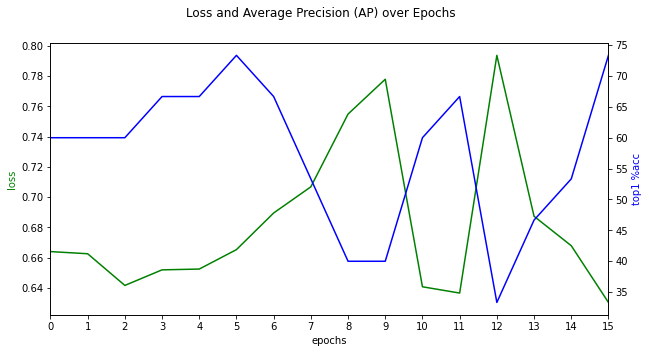

In [15]:
learner.fit(lr=LR, epochs=EPOCHS)

## Evaluate

Video datasets, composed of multiple videos, have varying video lengths. Yet our model only takes in clips of a set length. This is why we need to take into consideration two types of accuracies when evaluating our model: clip-level accuracy and video-level accuracy. 

Our classifications are set at the video level, which mean that each video is assigned 1 classification. However, each video could have hundreds or thousands of frames. To make sure we're getting a good range of clips across those frames, we can sample a single video (uniformly) a bunch of times. By default, our evaluation tool will sample 10 clips uniformly from each test video and pass it into the model in batches of [10 x 3 x (8 or 32) x 112 x 112]. This is where clip-level accuracy comes in. The direct results of the model will show us how many of those clips are correctly classified. 

Since our classifications are at the video level, we'll also want to see what our video-level accuracy is. We do this simply by average across the clip-level accuracy for each video.

In [16]:
ret = learner.evaluate()

15 samples of torch.Size([3, 8, 112, 112])
Avg. inference time per video (15 clips) = 202.02 ms
Video prediction accuracy = 0.43
Clip prediction accuracy = 0.49


## Predict

Now that we've developed a model that works, lets run a prediction on one of our videos and see how it works. We'll choose an image that's already downloaded to our disk, and run it through our `predict_video()` function.

In [17]:
test_vid = str(data_path()/"milkBottleActions"/"opening"/"01.mp4")

Total frames = 195


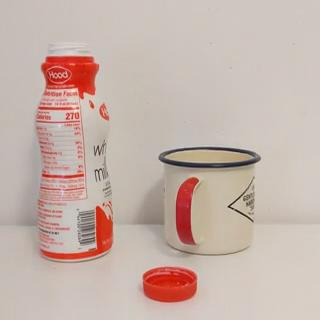

In [18]:
learner.predict_video(test_vid)

## Conclusion
Using the concepts introduced in this notebook, you can bring your own dataset and train an action recognition model to detect specific objects of interest for your scenarios.

In [ ]:
# Preserve some of the notebook outputs
sb.glue("vid_pred_accuracy", accuracy_score(ret["video_trues"], ret["video_preds"]))
sb.glue("clip_pred_accuracy", accuracy_score(ret["clip_trues"], ret["clip_preds"]))